In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

In [3]:
!pwd

/home/sailana/Desktop/new


In [2]:
# Plot display settings

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24
plt.rc('text', usetex=True)

In [3]:
# Useful for further computations

# def grad_F(x):
#     return A.T @ (A @ x - y) / n + lambd * x.T

def grad_f_i(A, i, y, lambd, x):
    return A[i, :] * (A[i, :].T @ x - y[i]) + lambd * x

def f_ridge(A, y, x, lambd):
    return la.norm(A @ x - y)**2 / (A.shape[0] * 2.0) + la.norm(x)**2 * lambd / 2.0

Analytical solution: 

$$
x^* = (\mathbf{A^T A} + \lambda n \mathbf{I})^{-1} \mathbf{A}^T y
$$

# SGD with Uniform Sampling for Ridge regression

In [4]:
def sgd_ridge_step(A, y, x, random_ind, lambd, step_size):
    grad = A[random_ind].T @ (A[random_ind] @ x - y[random_ind]) + lambd * x
    grad = np.array(grad)
    
    return  x - step_size * grad

In [5]:
def sgd(A, y, x_0, x_star, lambd, 
        step_size=1e-2, batch_size=1, 
        epsilon=1e-6, max_epoch=100, seed=42):
    
    np.random.seed(seed)
    
    x = x_0
    
    epoch_num = 0
    iter_num = 0
    
    error = [la.norm(x - x_star)**2]
    f_values = [f_ridge(A, y, x, lambd)]
    
    while epoch_num < max_epoch and error[-1] > epsilon: 
        
        random_ind = np.random.randint(A.shape[0], size=batch_size)
        x = sgd_ridge_step(A, y, x, random_ind, lambd, step_size)
        
        iter_num += 1
        
        f_values.append(f_ridge(A, y, x, lambd))
        error.append(la.norm(x - x_star)**2)
        
        if iter_num % A.shape[0] == 0:
            epoch_num += 1
            
#             f_values.append(f_ridge(A, y, x, lambd))
#             error.append(la.norm(x - x_star)**2)
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

#### Constant step size [Theorem 3.3]

In [6]:
# According to Theorem 3.3

def select_step_size(L_curly, mu, sigma_2, epsilon=1e-4):
    return 1 / (2 * L_curly)
#     Theorem corollary
#     return min(1 / (2 * L_curly), epsilon * sigma_2**2 / (4 * mu**2))

#### Decreasing step-size [Theorem 3.4]

In [7]:
# Decreasing step sizes

def adaptive_step_size(L_curly, mu, k, k_switch=None):
    if k_switch is None:
        k_switch = 4 * np.ceil(L_curly / mu) # equals \mathcal{L} * 4
#         cal_K = np.ceil(L_curly / mu)
        
    if k <= k_switch: #4 * cal_K:
        return 1 / (2 * L_curly)
    else:
        return (2 * k + 1) / (k + 1)**2 / mu        

In [8]:
def sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu,
                 k_switch=None, step_size=1e-2, batch_size=1, 
                 epsilon=1e-6, max_epoch=100, seed=42):
    
    np.random.seed(seed)
    
    x = x_0
    
    epoch_num = 0
    iter_num = 0
    
    error = [la.norm(x - x_star)**2]
    f_values = [f_ridge(A, y, x, lambd)]
    
    while epoch_num < max_epoch and error[-1] > epsilon: 
        iter_num += 1
        if k_switch is None:
            step_size = adaptive_step_size(L_curly, mu, k=iter_num)
        else:
            step_size = adaptive_step_size(L_curly, mu, iter_num, k_switch)
        random_ind = np.random.randint(A.shape[0], size=batch_size)
        x = sgd_ridge_step(A, y, x, random_ind, lambd, step_size)        
        
        f_values.append(f_ridge(A, y, x, lambd))
        error.append(la.norm(x - x_star)**2)    
            
        if iter_num % A.shape[0] == 0:
            epoch_num += 1
#             f_values.append(f_ridge(A, y, x, lambd))
#             error.append(la.norm(x - x_star)**2)    
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

In [33]:
n = 100
d = 30
lambd = 1 / n

In [93]:
np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)
# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

k_switch = int(4 * np.ceil(L_curly / mu))# / n)

step_size = select_step_size(L_curly, mu, sigma_2)
print("Step size:", step_size)

x_0 = np.random.normal(size=len(x_star))
max_epoch = 50

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch)

/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


Step size: 0.011111111111111112
Number of epochs: 50
Error: 0.11817456221105287

Number of epochs: 50
Error: 0.017183226322713047



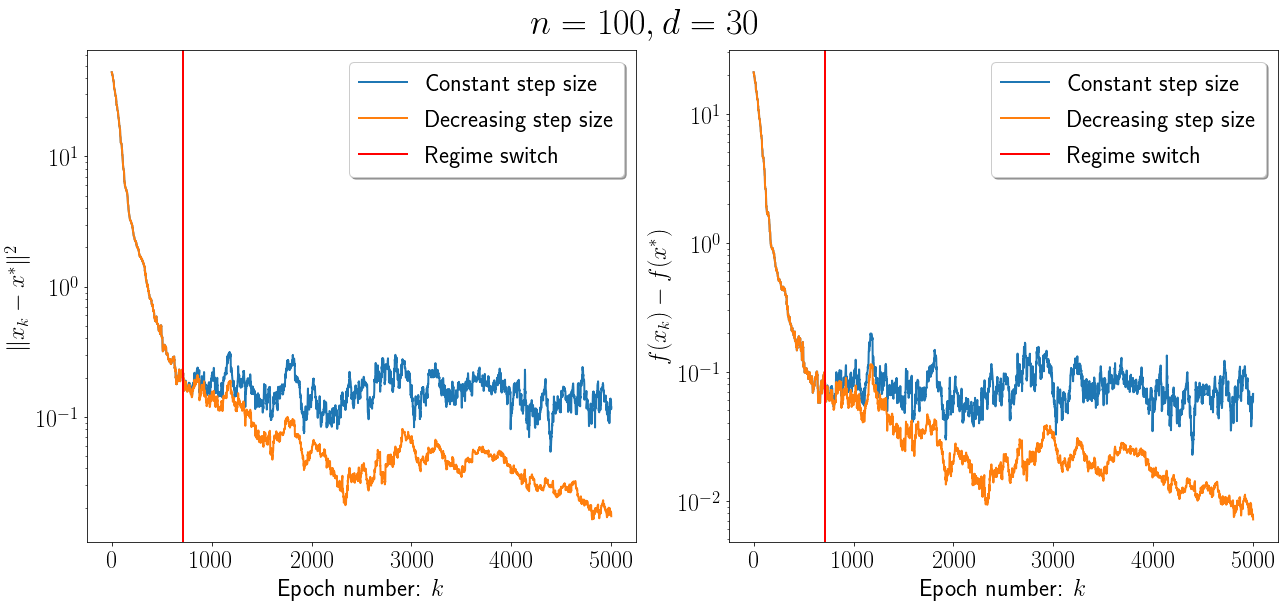

In [42]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err_const, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.axvline(k_switch, color='r', label="Regime switch")
#     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
#     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
#     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)

plt.subplot(1, 2, 2)

plt.semilogy(f_vals_const - f_ridge(A, y, x_star, lambd), label='Constant step size')
plt.semilogy(f_vals_adapt - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
plt.axvline(k_switch, color='r', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
fig.subplots_adjust(top=0.95)

#     plt.vlines()
plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [94]:
factor = 0.9

In [95]:
k_switch = int(4 * np.ceil(L_curly / mu))# / n)
k_varied_1 = k_switch * (1 - factor)

# Decreasing step-size
x_adapt_varied_1, f_vals_adapt_varied_1, x_err_adapt_varied_1 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_1)

Number of epochs: 50
Error: 0.01710910104433488



In [96]:
# k_switch = int(4 * np.ceil(L_curly / mu))# / n)
k_varied_2 = k_switch * (1 + factor)

# Decreasing step-size
x_adapt_varied_2, f_vals_adapt_varied_2, x_err_adapt_varied_2 = sgd_adaptive(A, y, x_0+1, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_2)

Number of epochs: 50
Error: 0.017096731238880742



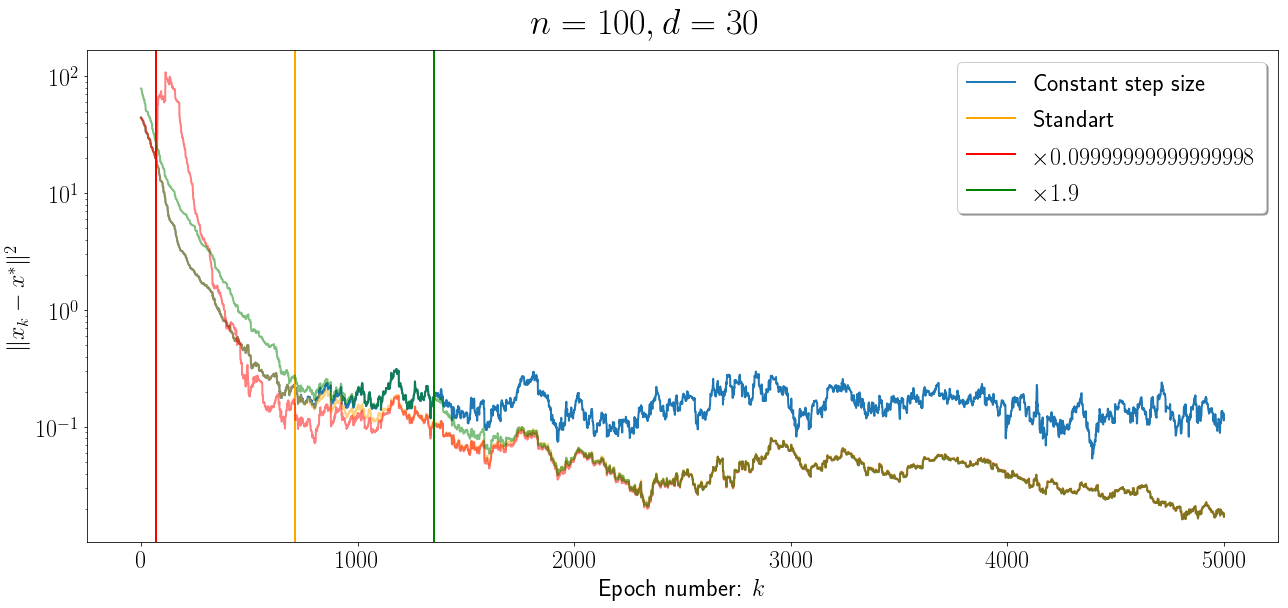

In [97]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.semilogy(x_err_const, label='Constant step size')

plt.semilogy(x_err_adapt, color='orange', alpha=0.5)#, label='Decreasing step size')
plt.axvline(k_switch, color='orange', label="Standart")#, label="Regime switch")

plt.semilogy(x_err_adapt_varied_1, color='r', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_1, color='r', label=r"$\times {}$".format(1 - factor))

plt.semilogy(x_err_adapt_varied_2, color='g', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_2, color='g', label=r"$\times {}$".format(1 + factor))

plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
# fig.subplots_adjust(top=0.95)

#     plt.vlines()
plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [187]:
n = 1000
d = 100

lambd = 1 / n

In [193]:
np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)
# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

k_switch = int(4 * np.ceil(L_curly / mu))# / n)

step_size = select_step_size(L_curly, mu, sigma_2)
print("Step size:", step_size)

x_0 = np.random.normal(size=len(x_star))
max_epoch = 50

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch)

/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


Step size: 0.003125
Number of epochs: 50
Error: 0.12049221642504636

Number of epochs: 50
Error: 0.0043108672322649125



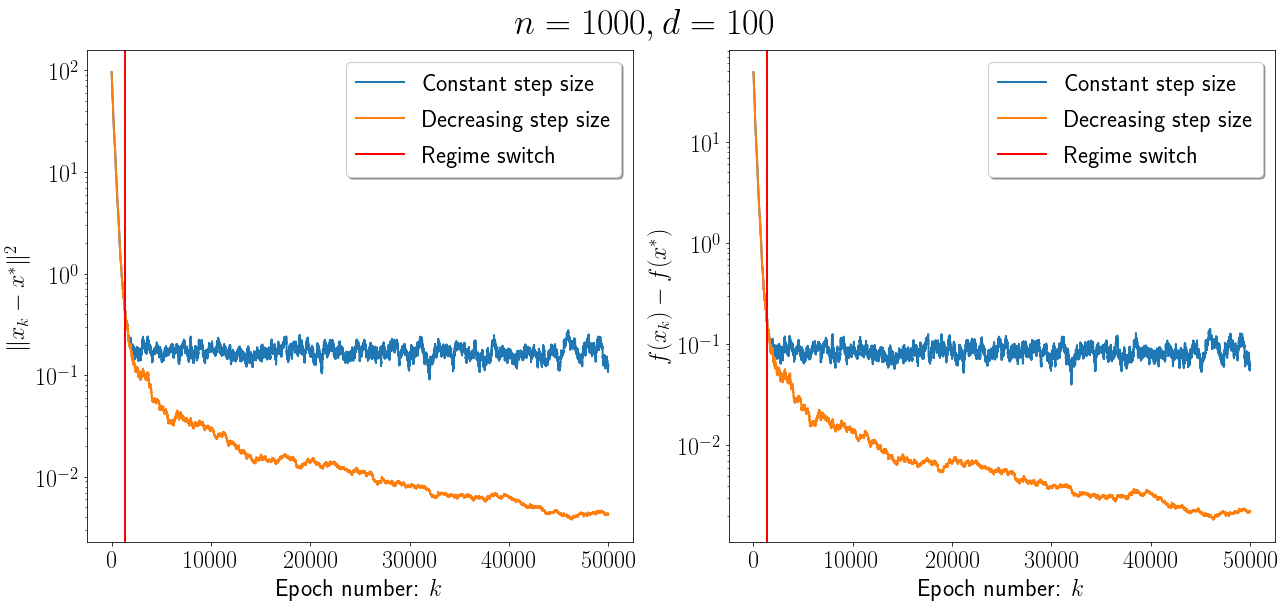

In [194]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err_const, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.axvline(k_switch, color='r', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)

plt.subplot(1, 2, 2)

plt.semilogy(f_vals_const - f_ridge(A, y, x_star, lambd), label='Constant step size')
plt.semilogy(f_vals_adapt - f_ridge(A, y, x_star, lambd), label='Decreasing step size')
plt.axvline(k_switch, color='r', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [12]:
factor = 0.9

In [13]:
k_switch = int(4 * np.ceil(L_curly / mu))# / n)
k_varied_1 = k_switch * (1 - factor)
k_varied_2 = k_switch * (1 + factor)

In [14]:
# Decreasing step-size
x_adapt_varied_1, f_vals_adapt_varied_1, x_err_adapt_varied_1 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_1)
# Decreasing step-size
x_adapt_varied_2, f_vals_adapt_varied_2, x_err_adapt_varied_2 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_2)

Number of epochs: 5
Error: 0.049757895980108754

Number of epochs: 5
Error: 0.04947533578720301



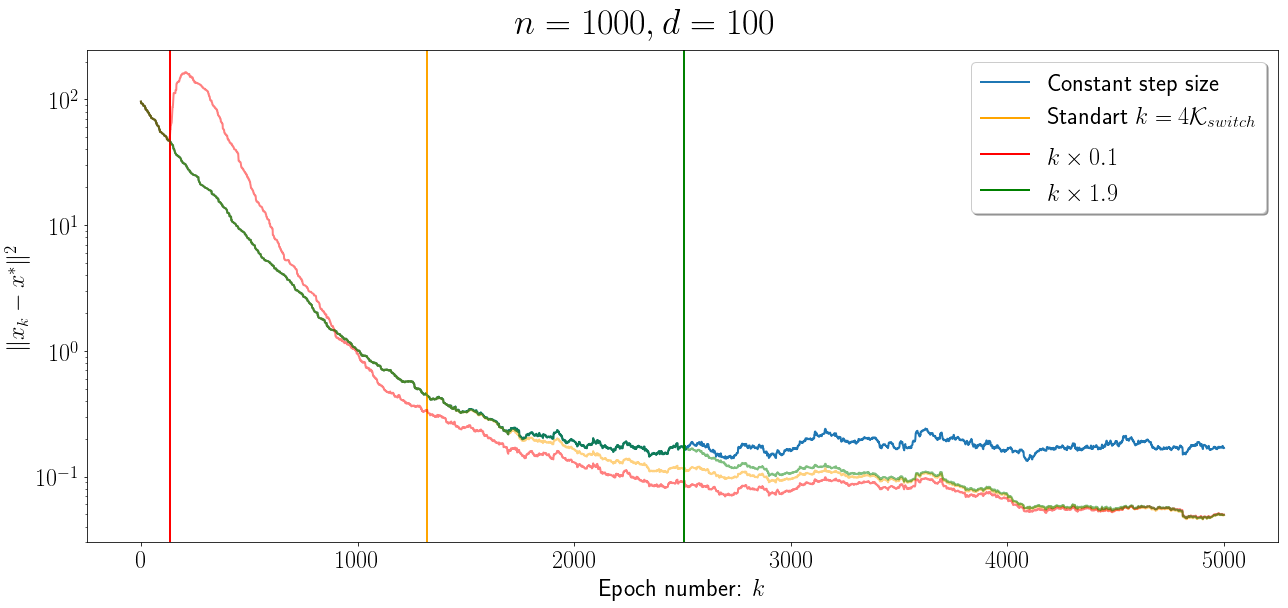

In [15]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.semilogy(x_err_const, label='Constant step size')

plt.semilogy(x_err_adapt, color='orange', alpha=0.5)#, label='Decreasing step size')
plt.axvline(k_switch, color='orange', label="Standart $k = 4 \mathcal{K}_{switch}$")#, label="Regime switch")

plt.semilogy(x_err_adapt_varied_1, color='r', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_1, color='r', label=r"$k \times {:0.1f}$".format(1 - factor))

plt.semilogy(x_err_adapt_varied_2, color='g', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_2, color='g', label=r"$k \times {:0.1f}$".format(1 + factor))

plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [119]:
def grad_k_func(k, mu, L_curly, r0_norm, sigma_2):
    return k * (1 - mu / (2 * L_curly))**k * (2 + k * np.log(1 - mu / (2 * L_curly))) + k**2 +\
           2 * sigma_2**2 / mu**2 * (k * mu / L_curly - 4)

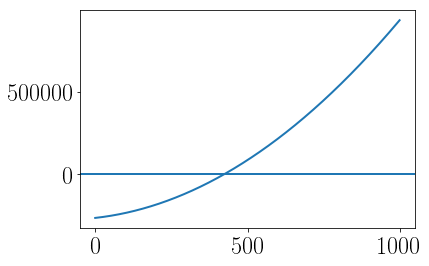

In [138]:
Grid = np.arange(0, 1000, 1)
plt.plot(Grid, k_func(Grid, mu, L_curly, la.norm(x_0 - x_star)**2, sigma_2))
plt.axhline()
plt.show()

In [16]:
r0_norm = la.norm(x_0 - x_star)**2

In [17]:
def k_func(k, mu, L_curly, r0_norm, sigma_2):
    return k**2 * (1 - mu / (2 * L_curly))**k * r0_norm +\
           sigma_2**2 / mu**2 * (k**2 * mu / L_curly - 8 * k)

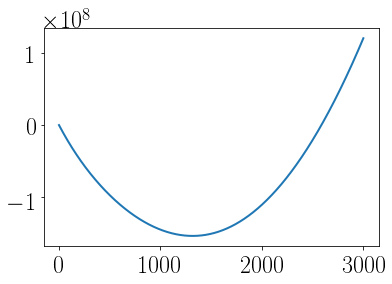

In [31]:
Grid = np.arange(0, 3000, 1)
plt.plot(Grid, k_func(Grid, mu, L_curly, la.norm(x_0 - x_star)**2, sigma_2))
# plt.axhline()
plt.show()

In [18]:
from scipy.optimize import minimize_scalar

In [32]:
r0_norm = la.norm(x_0 - x_star)**2
result = minimize_scalar(lambda k: k_func(k, mu, L_curly, r0_norm, sigma_2), bounds=(0, None))
k_opt = result.x
result

     fun: -153582240.42944834
    nfev: 16
     nit: 8
 success: True
       x: 1316.943241119143

In [12]:
factor = 0.9

In [13]:
k_switch = int(4 * np.ceil(L_curly / mu))# / n)
k_varied_1 = k_switch * (1 - factor)
k_varied_2 = k_switch * (1 + factor)

In [33]:
# Decreasing step-size
x_adapt_varied_1, f_vals_adapt_varied_1, x_err_adapt_varied_1 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_1)

x_adapt_varied_2, f_vals_adapt_varied_2, x_err_adapt_varied_2 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_2)
# 
x_adapt_varied_opt, f_vals_adapt_varied_opt, x_err_adapt_varied_opt = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                                   L_curly, mu, max_epoch=max_epoch, k_switch=k_opt)

Number of epochs: 5
Error: 0.049757895980108754

Number of epochs: 5
Error: 0.04947533578720301

Number of epochs: 5
Error: 0.04922968135906214



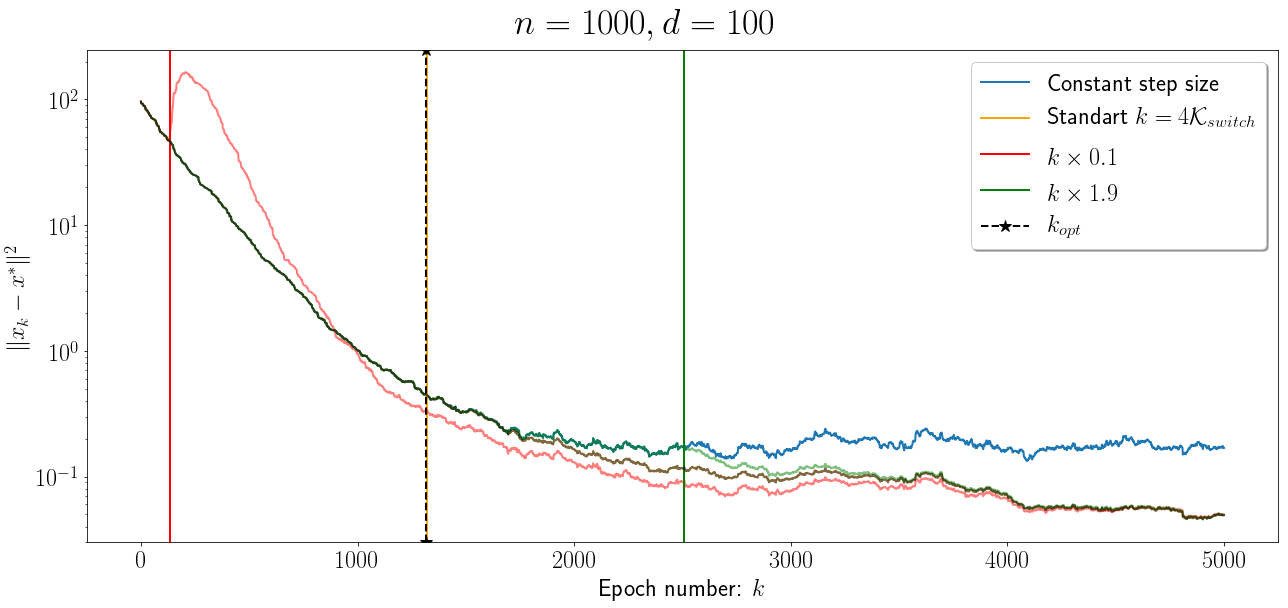

In [41]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.semilogy(x_err_const, label='Constant step size')

plt.semilogy(x_err_adapt, color='orange', alpha=0.5)#, label='Decreasing step size')
plt.axvline(k_switch, color='orange', label="Standart $k = 4 \mathcal{K}_{switch}$")#, label="Regime switch")

plt.semilogy(x_err_adapt_varied_1, color='r', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_1, color='r', label=r"$k \times {:0.1f}$".format(1 - factor))

plt.semilogy(x_err_adapt_varied_2, color='g', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_2, color='g', label=r"$k \times {:0.1f}$".format(1 + factor))

plt.semilogy(x_err_adapt_varied_opt, color='black', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_opt, color='black', marker='*', linestyle="dashed", label=r"$k_{opt}$")

plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [43]:
n = 100
d = 10

lambd = 1 / n

In [44]:
np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)
# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

k_switch = int(4 * np.ceil(L_curly / mu))# / n)

step_size = select_step_size(L_curly, mu, sigma_2)
print("Step size:", step_size)

x_0 = np.random.normal(size=len(x_star))
max_epoch = 5

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch)

Step size: 0.020833333333333332
Number of epochs: 5
Error: 0.16673261436129377

Number of epochs: 5
Error: 0.04268826705603036



/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


In [45]:
r0_norm = la.norm(x_0 - x_star)**2
result = minimize_scalar(lambda k: k_func(k, mu, L_curly, r0_norm, sigma_2), bounds=(0, None))
k_opt = result.x
result

     fun: -47553.94351292783
    nfev: 20
     nit: 10
 success: True
       x: 158.35630546988844

In [47]:
factor = 0.9

k_switch = int(4 * np.ceil(L_curly / mu))# / n)
k_varied_1 = k_switch * (1 - factor)
k_varied_2 = k_switch * (1 + factor)

r0_norm = la.norm(x_0 - x_star)**2
k_opt = minimize_scalar(lambda k: k_func(k, mu, L_curly, r0_norm, sigma_2), bounds=(0, None)).x

In [48]:
# Decreasing step-size
x_adapt_varied_1, f_vals_adapt_varied_1, x_err_adapt_varied_1 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_1)

x_adapt_varied_2, f_vals_adapt_varied_2, x_err_adapt_varied_2 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_2)
# 
x_adapt_varied_opt, f_vals_adapt_varied_opt, x_err_adapt_varied_opt = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                                   L_curly, mu, max_epoch=max_epoch, k_switch=k_opt)

Number of epochs: 5
Error: 0.042324175301266566

Number of epochs: 5
Error: 0.048415411097144055

Number of epochs: 5
Error: 0.042691770825952276



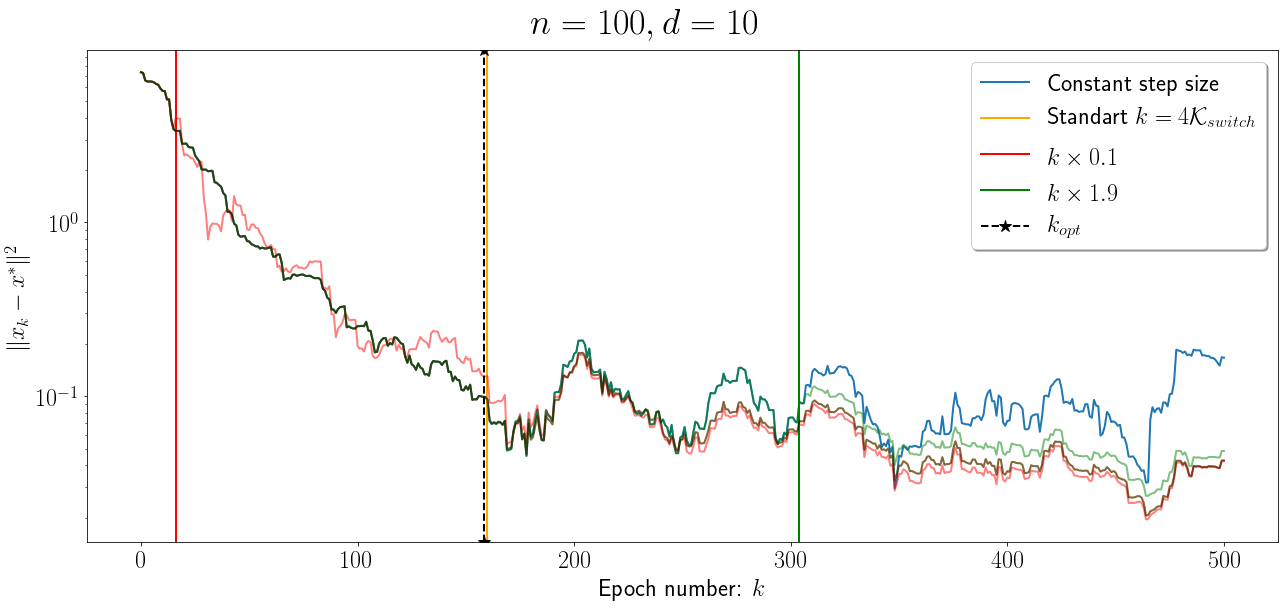

In [49]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.semilogy(x_err_const, label='Constant step size')

plt.semilogy(x_err_adapt, color='orange', alpha=0.5)#, label='Decreasing step size')
plt.axvline(k_switch, color='orange', label="Standart $k = 4 \mathcal{K}_{switch}$")#, label="Regime switch")

plt.semilogy(x_err_adapt_varied_1, color='r', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_1, color='r', label=r"$k \times {:0.1f}$".format(1 - factor))

plt.semilogy(x_err_adapt_varied_2, color='g', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_2, color='g', label=r"$k \times {:0.1f}$".format(1 + factor))

plt.semilogy(x_err_adapt_varied_opt, color='black', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_opt, color='black', marker='*', linestyle="dashed", label=r"$k_{opt}$")

plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [261]:
n = 1000
d = 100

lambd = 1 / n

In [262]:
np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)
# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

k_switch = int(4 * np.ceil(L_curly / mu))# / n)

step_size = select_step_size(L_curly, mu, sigma_2)
print("Step size:", step_size)

Step size: 0.003125


/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


In [263]:
eps = 3

In [264]:
x_0 = x_star + eps * np.random.normal(size=len(x_star))
max_epoch = 5

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch)

Number of epochs: 5
Error: 0.16835818952779297

Number of epochs: 5
Error: 0.05474340382047115



In [265]:
la.norm(np.random.normal(size=len(x_star)) - x_star)**2

105.1061486237479

In [266]:
factor = 0.7

k_switch = int(4 * np.ceil(L_curly / mu))# / n)
k_varied_1 = k_switch * (1 - factor)
k_varied_2 = k_switch * (1 + factor)

r0_norm = la.norm(x_0 - x_star)**2
print("||r_o||^2 = {}$".format(r0_norm))

result = minimize_scalar(lambda k: k_func(k, mu, L_curly, r0_norm, sigma_2), bounds=(0, None))
k_opt = result.x
result
# k_opt = minimize_scalar(lambda k: k_func(k, mu, L_curly, r0_norm, sigma_2), bounds=(0, None)).x

||r_o||^2 = 864.5545992656096$


     fun: -23976210.654980164
    nfev: 16
     nit: 10
 success: True
       x: 214.19685535437102

In [267]:
# Decreasing step-size
x_adapt_varied_1, f_vals_adapt_varied_1, x_err_adapt_varied_1 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_1)

x_adapt_varied_2, f_vals_adapt_varied_2, x_err_adapt_varied_2 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_2)
# Optimal k for regime switch
x_adapt_varied_opt, f_vals_adapt_varied_opt, x_err_adapt_varied_opt = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                                   L_curly, mu, max_epoch=max_epoch, k_switch=k_opt)

Number of epochs: 5
Error: 0.0498193000153848

Number of epochs: 5
Error: 0.051638618312452464

Number of epochs: 5
Error: 0.04946359739920718



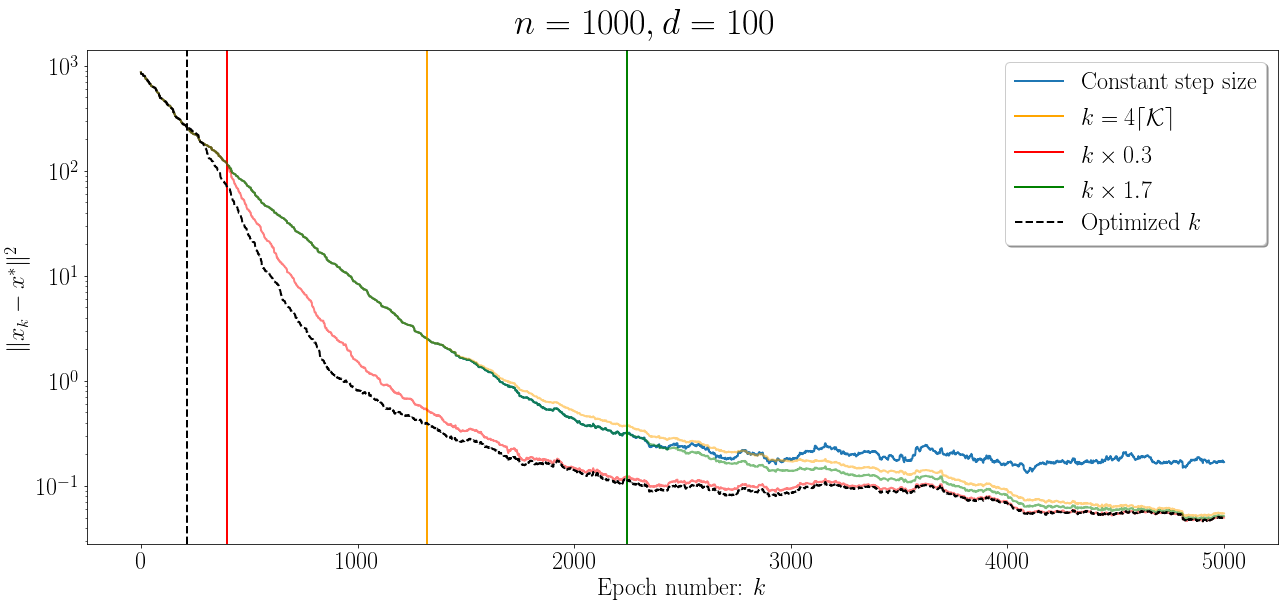

In [269]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.semilogy(x_err_const, label='Constant step size')

plt.semilogy(x_err_adapt, color='orange', alpha=0.5)#, label='Decreasing step size')
plt.axvline(k_switch, color='orange', label="$k = 4 \lceil \mathcal{K}$"
                                            r"$\displaystyle\rceil$")#, label="Regime switch")

plt.semilogy(x_err_adapt_varied_1, color='r', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_1, color='r', label=r"$k \times {:0.1f}$".format(1 - factor))

plt.semilogy(x_err_adapt_varied_2, color='g', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_2, color='g', label=r"$k \times {:0.1f}$".format(1 + factor))

plt.semilogy(x_err_adapt_varied_opt, color='black', linestyle="dashed")#, label='Varied k switch')
plt.axvline(k_opt, color='black', linestyle="dashed", label=r"Optimized $k$")

plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('x0_far_from_solution_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [252]:
n = 1000
d = 100

lambd = 1 / n

In [253]:
np.random.seed(0)

A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)
# Matrix normalization for ||A[i,:]||_2 = 1
# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

# Analytical solution
x_star = la.inv(A.T @ A + lambd * n * np.eye(d)) @ A.T @ y

# Problem constants
mu = min(np.linalg.eigvals(A.T @ A)) / n + lambd
L = la.norm(A, axis=1, ord=2)**2 + lambd

M = [np.outer(A[i], A[i]) + lambd * np.eye(d) for i in range(n)]

sigma_2 = sum([la.norm(grad_f_i(A, i, y, lambd, x_star))**2 for i in range(n)]) / n
L_curly = int(max([max(la.eigvals(M[i])) for i in range(len(M))]))

k_switch = int(4 * np.ceil(L_curly / mu))# / n)

step_size = select_step_size(L_curly, mu, sigma_2)
print("Step size:", step_size)

Step size: 0.003125


/Users/Shulgin_Egor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


In [254]:
eps = 0.1

In [255]:
x_0 = x_star + eps * np.random.normal(size=len(x_star))
max_epoch = 5

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, max_epoch=max_epoch)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_curly, mu, max_epoch=max_epoch)

Number of epochs: 5
Error: 0.16874062707477128

Number of epochs: 5
Error: 0.04859672874568406



In [256]:
factor = 0.7

k_switch = int(4 * np.ceil(L_curly / mu))# / n)
k_varied_1 = k_switch * (1 - factor)
k_varied_2 = k_switch * (1 + factor)

r0_norm = la.norm(x_0 - x_star)**2
print("||r_o||^2 = {}$".format(r0_norm))

result = minimize_scalar(lambda k: k_func(k, mu, L_curly, r0_norm, sigma_2), bounds=(0, None))
k_opt = result.x
result
# k_opt = minimize_scalar(lambda k: k_func(k, mu, L_curly, r0_norm, sigma_2), bounds=(0, None)).x

||r_o||^2 = 0.9606162214062329$


     fun: -175836099.34116548
    nfev: 14
     nit: 7
 success: True
       x: 1316.7980106798698

In [257]:
# Decreasing step-size
x_adapt_varied_1, f_vals_adapt_varied_1, x_err_adapt_varied_1 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_1)

x_adapt_varied_2, f_vals_adapt_varied_2, x_err_adapt_varied_2 = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                             L_curly, mu, max_epoch=max_epoch, k_switch=k_varied_2)
# Optimal k for regime switch
x_adapt_varied_opt, f_vals_adapt_varied_opt, x_err_adapt_varied_opt = sgd_adaptive(A, y, x_0, x_star, lambd, 
                                                                                   L_curly, mu, max_epoch=max_epoch, k_switch=k_opt)

Number of epochs: 5
Error: 0.04858470366741398

Number of epochs: 5
Error: 0.04894867601261854

Number of epochs: 5
Error: 0.04859655929836805



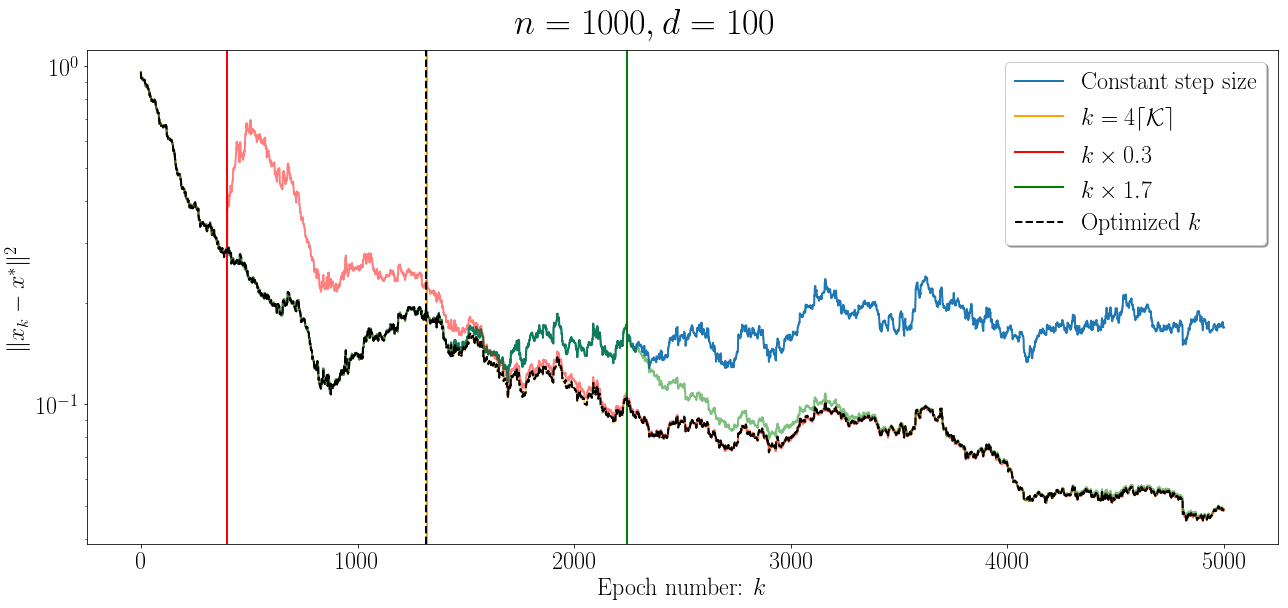

In [260]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.semilogy(x_err_const, label='Constant step size')

plt.semilogy(x_err_adapt, color='orange', alpha=0.5)#, label='Decreasing step size')
plt.axvline(k_switch, color='orange', label=r"$k = 4 \lceil \mathcal{K}$"
                                            r"$\displaystyle\rceil$")#, label="Regime switch")

plt.semilogy(x_err_adapt_varied_1, color='r', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_1, color='r', label=r"$k \times {:0.1f}$".format(1 - factor))

plt.semilogy(x_err_adapt_varied_2, color='g', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_2, color='g', label=r"$k \times {:0.1f}$".format(1 + factor))

plt.semilogy(x_err_adapt_varied_opt, color='black', linestyle="dashed")#, label='Varied k switch')
plt.axvline(k_opt, color='black', linestyle="dashed", label=r"Optimized $k$")

plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('x0_close_to_solution_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

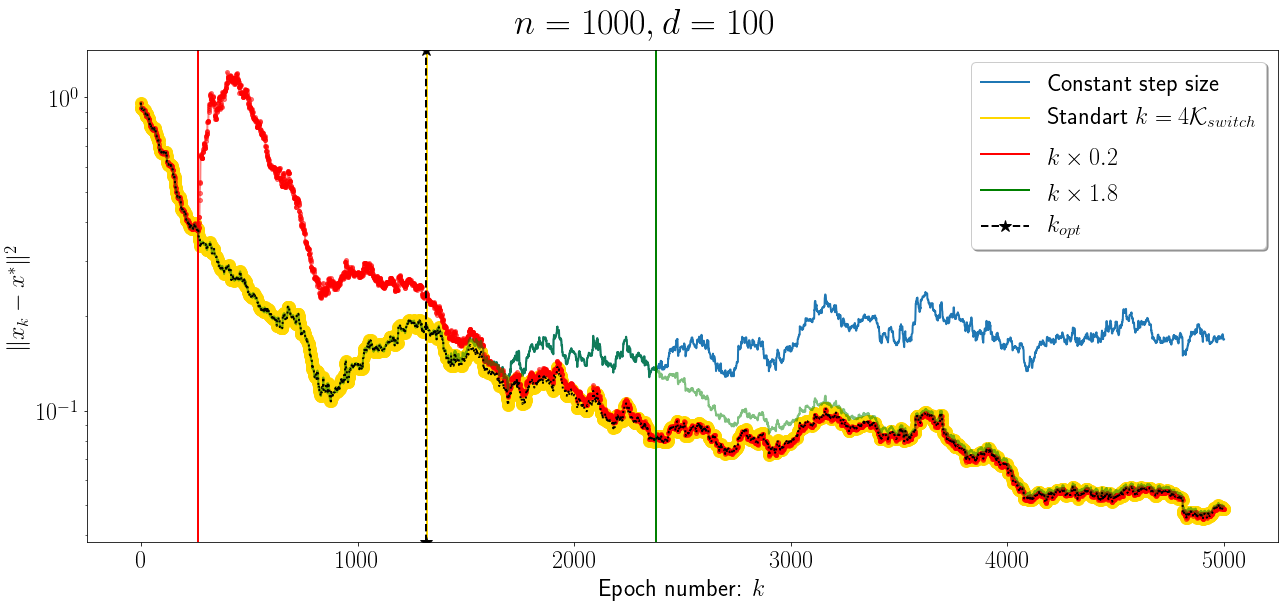

In [147]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.semilogy(x_err_const, label='Constant step size')

plt.semilogy(x_err_adapt, color='gold', marker="o")#, alpha=0.5)#, label='Decreasing step size')
plt.axvline(k_switch, color='gold', label="Standart $k = 4 \mathcal{K}_{switch}$")#, label="Regime switch")

# plt.scatter(x_err_adapt_varied_1, color='r', marker="*", markersize=5, alpha=0.5)
# plt.xscale('log')
plt.semilogy(x_err_adapt_varied_1, color='r', marker=".", markersize=8, alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_1, color='r', label=r"$k \times {:0.1f}$".format(1 - factor))

plt.semilogy(x_err_adapt_varied_2, color='g', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_2, color='g', label=r"$k \times {:0.1f}$".format(1 + factor))

plt.semilogy(x_err_adapt_varied_opt, color='black', linestyle=":")#, label='Varied k switch')
plt.axvline(k_opt, color='black', marker='*', linestyle="dashed", label=r"$k_{optimal}$")

plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('x0_close_to_solution_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

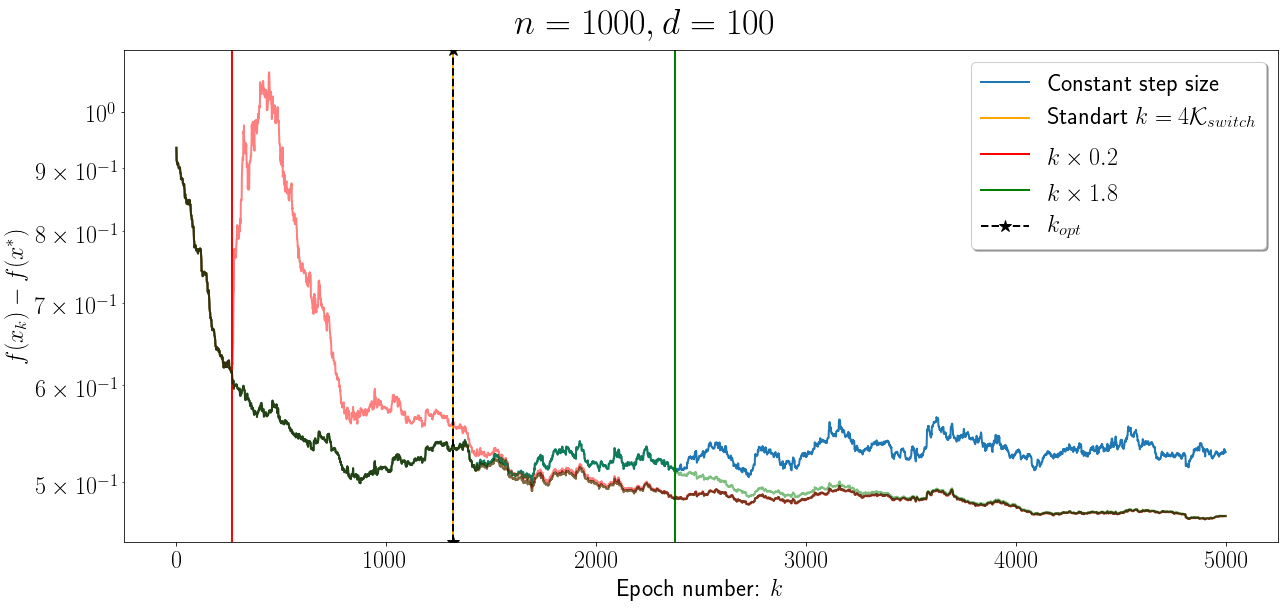

In [120]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.semilogy(f_vals_const, label='Constant step size')

plt.semilogy(f_vals_adapt, color='orange', alpha=0.5)#, label='Decreasing step size')
plt.axvline(k_switch, color='orange', label="Standart $k = 4 \mathcal{K}_{switch}$")#, label="Regime switch")

plt.semilogy(f_vals_adapt_varied_1, color='r', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_1, color='r', label=r"$k \times {:0.1f}$".format(1 - factor))

plt.semilogy(f_vals_adapt_varied_2, color='g', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_varied_2, color='g', label=r"$k \times {:0.1f}$".format(1 + factor))

plt.semilogy(f_vals_adapt_varied_opt, color='black', alpha=0.5)#, label='Varied k switch')
plt.axvline(k_opt, color='black', marker='*', linestyle="dashed", label=r"$k_{opt}$")

plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
# plt.savefig('x0_close_to_solution_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()